# Pathology prediction (EDEMA)


@References : Soenksen, L.R., Ma, Y., Zeng, C. et al. Integrated multimodal artificial intelligence framework for healthcare applications. npj Digit. Med. 5, 149 (2022). https://doi.org/10.1038/s41746-022-00689-4

In this notebook, the task is to predict the EDEMA pathology using the CSV embeddings file


## Introduction


Radiology notes were processed to determine if each of the pathologies was explicitly confirmed as present (value = 1), explicitly confirmed as absent (value = 0), inconclusive in the study (value = −1), or not explored (no value).

Selected samples : 0 or 1 values (removing the rest from the training and testing data).

Excluded variables : the unstructured radiology notes component (E_rad ) from the allowable input to avoid potential overfitting or misrepresentations of real predictive value.

The model is based on binary classification for each target chest pathology.

Final sample size for the EDEMA pathology is : (N = 17,182)
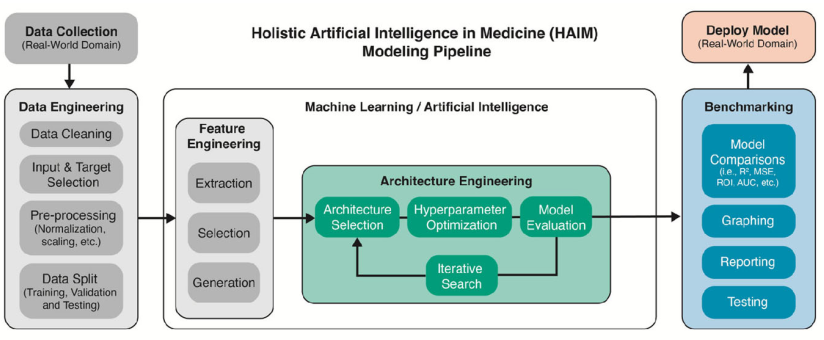

#### Imports

In [1]:
import os
os.chdir('../')

from src.data.dataset import HAIMDataset
from src.data.sampling import Sampler
from src.data.constants import *
from src.evaluation.evaluating import Evaluator
from src.evaluation.tuning import SklearnTuner
from src.utils.metric_scores import *
from xgboost import XGBClassifier
from pandas import read_csv


#### Read data from local source



In [4]:
df = read_csv(FILE_DF, nrows=N_DATA)


#### Create a custom dataset for the HAIM experiment


Build the target column for the task at hand, set the dataset specificities:  the ``haim_id`` as a ``global_id``, use all sources except ``radiology notes`` 

In [5]:
dataset = HAIMDataset(df,  CHEST_PREDICTORS, ALL_MODALITIES, EDEMA, IMG_ID, GLOBAL_ID)


#### Create the sampler


Sample the data using a 5 folds cross-validation method based on unique ``haim_id`` 

In [7]:
sampler = Sampler(dataset, GLOBAL_ID, 5)
_, masks = sampler()

100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 2788.77it/s]


#### Select the evaluation metrics

Initilialize a list containing the evaluation metrics to report

In [8]:
# Initialization of the list containing the evaluation metrics
evaluation_metrics = [BinaryAccuracy(), BinaryBalancedAccuracy(),
                      BinaryBalancedAccuracy(Reduction.GEO_MEAN),
                      Sensitivity(), Specificity(), AUC(), BrierScore(),
                      BinaryCrossEntropy()]

#### Set hyper-parameters and fixed parameters

In [9]:
# Define the grid oh hyper-parameters for the tuning
grid_hps = {'max_depth': [5, 6, 7, 8],
            'n_estimators': [200, 300],
            'learning_rate': [0.3, 0.1, 0.05],
            }

# Save the fixed parameters of the model
fixed_params = {'seed': 42,
                'eval_metric': 'logloss',
                'verbosity': 0
                }

### Model training and predictions using an XGBClassifier model with GridSearchCV and Hyperparameters optimization


The goal of this section of the notebook is to compute the following metrics:

``ACCURACY_SCORE, BALANCED_ACCURACY_SCORE, SENSITIVITY, SPECIFICITY, AUC, BRIER SCORE, BINARY CROSS-ENTROPY``


The
hyperparameter combinations of individual XGBoost models were
selected within each training loop using a ``fivefold cross-validated
grid search`` on the training set (80%). This XGBoost ``tuning process``
selected the ``maximum depth of the trees (5–8)``, the number of
``estimators (200 or 300)``, and the ``learning rate (0.05, 0.1, 0.3)``
according to the parameter value combination leading to the
highest observed AUROC within the training loop 


As mentioned previously, all XGBoost models were trained ``five times with five different data splits`` to repeat the
experiments and compute average metrics 


```Refer to page 8 of study``` : https://doi.org/10.1038/s41746-022-00689-4

In [14]:
evaluation = Evaluator(dataset=dataset,
                       masks=masks,
                       metrics=evaluation_metrics,
                       model=XGBClassifier,
                       tuner=SklearnTuner,
                       tuning_metric=AUC(),
                       hps=grid_hps,
                       n_tuning_splits=5,
                       fixed_params=fixed_params,
                       filepath=EXPERIMENT_PATH,
                       weight='scale_pos_weight',
                       evaluation_name='CP_Edema'
                       )
evaluation.evaluate()


#### Comparison with the paper results:






In [2]:
Evaluator.visualize_results('experiments/CP_Edema', EDEMA)

,Accuracy,BalancedAcc,GeoBalancedAcc,Sensitivity,Specificity,AUC,BrierScore,BCE
train_metrics,1.0 +- 0.0,1.0 +- 0.0,1.0 +- 0.0,1.0 +- 0.0,1.0 +- 0.0,1.0 +- 0.0,0.0011 +- 0.0012,0.0222 +- 0.0129
test_metrics,0.8084 +- 0.0148,0.8244 +- 0.0053,0.8208 +- 0.007,0.7594 +- 0.0459,0.8895 +- 0.038,0.9147 +- 0.0072,0.1151 +- 0.0059,0.383 +- 0.0182
HAIM,--,--,--,--,--,0.917,--,--
NON_HAIM,--,--,--,--,--,0.912,--,--
